# Aizawa Generation Acceleration

#### Created by Group B (PYNQ IMAGEINE): cakeforcat, Kandor9178 & sark02    (Github usernames)

Purpose: <br>Submission for University of Strathclyde course: EE315 Further VHDL and FPGA Design <br>

Decription: <br>This file contains the software and hardware implementation of the Heun method to generate the coordinates of the 3D Aizawa strange attractor. The two methods are timed to be compared to prove that the parallel architecture of the programmable logic (PL) can generate the required coordinates faster than the processing subsystem (PS).

### Software implementation:
##### Include relevant libraries:
matplotlib and mpl_toolkits for plotting image <br>
time to record elapsed time of processes

In [32]:
%matplotlib notebook
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import time

##### Generate the derivative functions for Aizawa:

In [33]:
def dx(x,y,z):
    result = (z-0.7)*x-3.5*y
    return result

def dy(x,y,z):
    result = 3.5*x+(z-0.7)*y
    return result

def dz(x,y,z):
    result = 0.6+0.95*z-pow(z,3)/3-(pow(x,2)+pow(y,2))*(1+0.25*z)+0.1*z*pow(x,3)
    return result

##### Generate coordinates of Aizawa using RK4:

In [34]:
iterations = 30000

x=[]
x = [0 for i in range(iterations+1)]
y=[]
y = [0 for i in range(iterations+1)]
z=[]
z = [0 for i in range(iterations+1)]

x[0] = 1
y[0] = 1
z[0] = 1
h  = 0.01     #Step size

start = time.time()
for i in range(1,iterations):
    k1 = dx(x[i-1],y[i-1],z[i-1])
    l1 = dy(x[i-1],y[i-1],z[i-1])
    m1 = dz(x[i-1],y[i-1],z[i-1])
    
    k2 = dx(x[i-1]+h*k1, y[i-1]+h*l1, z[i-1]+h*m1)
    l2 = dy(x[i-1]+h*k1, y[i-1]+h*l1, z[i-1]+h*m1)
    m2 = dz(x[i-1]+h*k1, y[i-1]+h*l1, z[i-1]+h*m1)         
            
    x[i] = x[i-1]+0.5*h*(k1 + k2)
    y[i] = y[i-1]+0.5*h*(l1 + l2)
    z[i] = z[i-1]+0.5*h*(m1 + m2)
elapsed_time = time.time() - start
print("Time to generate points = ", elapsed_time, " seconds")

Time to generate points =  0.22844457626342773  seconds


##### Plot software results:

<IPython.core.display.Javascript object>


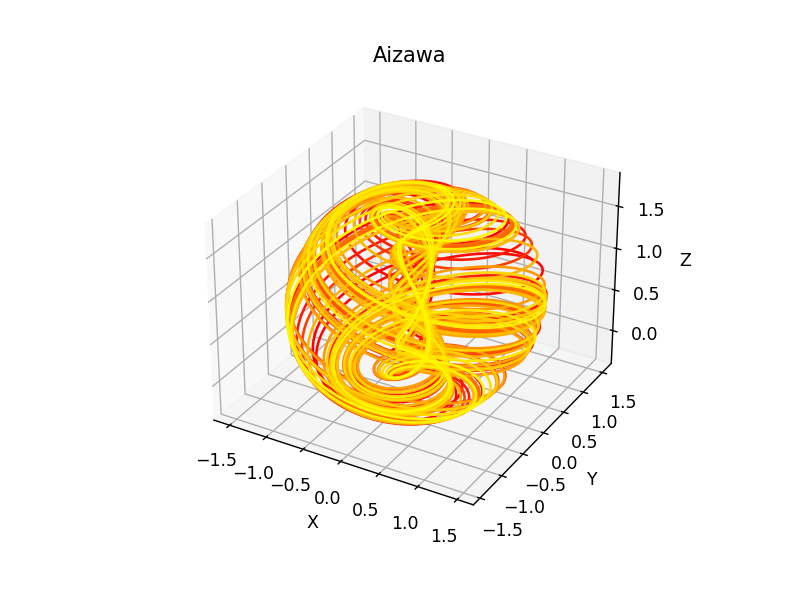

Time to plot points =  0.13635015487670898  seconds


In [35]:
start = time.time()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
steps = int(iterations/1000)
iterationNew = int(iterations/steps)
plotXSoft=[]
plotXSoft = [0 for i in range(iterationNew)]
plotYSoft=[]
plotYSoft = [0 for i in range(iterationNew)]
plotZSoft=[]
plotZSoft = [0 for i in range(iterationNew)]
for j in range(0,steps):
    color = plt.cm.autumn(j/steps)
    for i in range(0,iterationNew):
        if j!=0 and i == 0:     #So new set of points start at last and not the one after leaving gaps in the plot
            plotXSoft[i] = x[j*iterationNew + i-1]
            plotYSoft[i] = y[j*iterationNew + i-1]
            plotZSoft[i] = z[j*iterationNew + i-1]
        else:    
            plotXSoft[i] = x[j*iterationNew + i]
            plotYSoft[i] = y[j*iterationNew + i]
            plotZSoft[i] = z[j*iterationNew + i]
    ax.plot3D(plotXSoft, plotYSoft, plotZSoft, color=color)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Aizawa')
plt.show()

elapsed_time = time.time() - start
print("Time to plot points = ", elapsed_time, " seconds" )

### Hardware implementation:
##### Import Aizawa hardware:

In [36]:
from pynq import Overlay
ol = Overlay("aizawa.bit")
ol?
aizawa = ol.aizheun_0

ModuleNotFoundError: No module named 'pynq'

##### Create binary to float conversion:
Communication between software and hardware transfers 32 bits at a time; to allow for correct range and precision of expected results 8 integer bits were transferred and 24 fractional bits and is a signed number. When recieved, this binary formatting needs to be scaled back to float for plotting.

In [37]:
def binary_to_float(val):
    return float(val-(2**32)*int(str((val)>>(32-1))))/(2**24)

##### Generate results from hardware:

In [38]:
%%time

iterations = 30000

xBin = 16777216    #Start point of 1 when in binary transfer format
yBin = 16777216
zBin = 16777216
xvalshw = []
yvalshw = []
zvalshw = []
xvalshw.append(binary_to_float(xBin))
yvalshw.append(binary_to_float(yBin))
zvalshw.append(binary_to_float(zBin))
    
for i in range(iterations):
    aizawa.write(0x08, xBin)
    aizawa.write(0x04, yBin)
    aizawa.write(0x00, zBin)
    xBin = fourwing.read(0x0C)
    yBin = fourwing.read(0x10)
    zBin = fourwing.read(0x14)
    xvalshw.append(binary_to_float(xBin))
    yvalshw.append(binary_to_float(yBin))
    zvalshw.append(binary_to_float(zBin))

NameError: name 'aizawa' is not defined

##### Plot hardware results:

In [39]:
start = time.time()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
steps = int(iterations/1000)
iterationNew = int(iterations/steps)
plotXHard=[]
plotXHard = [0 for i in range(iterationNew)]
plotYHard=[]
plotYHard = [0 for i in range(iterationNew)]
plotZHard=[]
plotZHard = [0 for i in range(iterationNew)]
for j in range(0,steps):
    colorSoft = plt.cm.spring(j/steps)
    colorHard = plt.cm.summer(j/steps)
    for i in range(0,iterationNew):
        if j!=0 and i == 0:     #So new set of points start at last and not the one after leaving gaps in the plot
            plotXHard[i] = xvalshw[j*iterationNew + i-1]
            plotYHard[i] = yvalshw[j*iterationNew + i-1]
            plotZHard[i] = zvalshw[j*iterationNew + i-1]
            
            plotXSoft[i] = x[j*iterationNew + i-1]
            plotYSoft[i] = y[j*iterationNew + i-1]
            plotZSoft[i] = z[j*iterationNew + i-1]
        else:    
            plotXHard[i] = xvalshw[j*iterationNew + i]
            plotYHard[i] = yvalshw[j*iterationNew + i]
            plotZHard[i] = zvalshw[j*iterationNew + i]
            
            plotXSoft[i] = x[j*iterationNew + i]
            plotYSoft[i] = y[j*iterationNew + i]
            plotZSoft[i] = z[j*iterationNew + i]
    ax.plot3D(plotXHard, plotYHard, plotZHard, color=colorHard)
    ax.plot3D(plotXSoft, plotYSoft, plotZSoft, color=colorSoft)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Aizawa')
plt.show()

elapsed_time = time.time() - start
print("Time to plot points = ", elapsed_time, " seconds" )

<IPython.core.display.Javascript object>

IndexError: list index out of range

### Comparison of Two Methods:
##### Graphical Comparison:

<IPython.core.display.Javascript object>


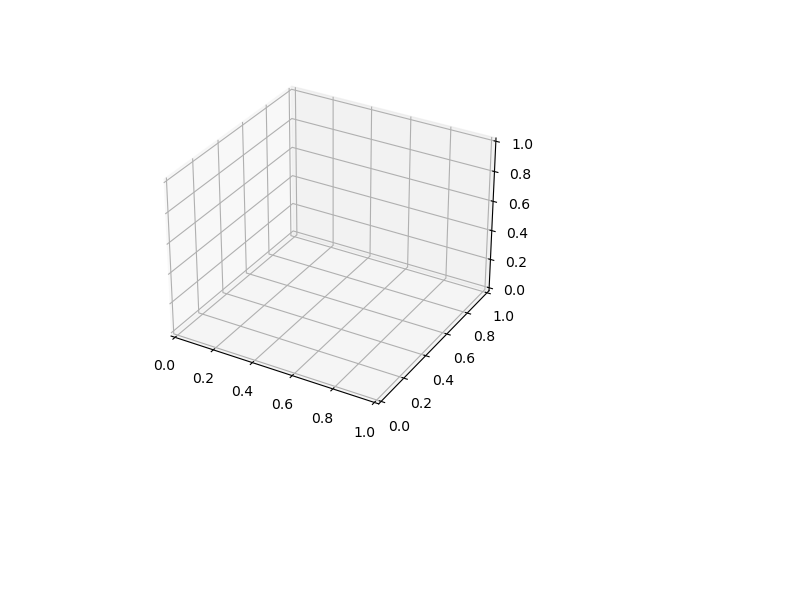

IndexError: list index out of range

In [40]:
start = time.time()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for j in range(0,steps):
    colorSoft = plt.cm.spring(j/steps)
    colorHard = plt.cm.summer(j/steps)
    for i in range(0,iterationNew):
        if j!=0 and i == 0:     #So new set of points start at last and not the one after leaving gaps in the plot
            plotXHard[i] = xvalshw[j*iterationNew + i-1]
            plotYHard[i] = yvalshw[j*iterationNew + i-1]
            plotZHard[i] = zvalshw[j*iterationNew + i-1]
            
            plotXSoft[i] = x[j*iterationNew + i-1]
            plotYSoft[i] = y[j*iterationNew + i-1]
            plotZSoft[i] = z[j*iterationNew + i-1]
        else:    
            plotXHard[i] = xvalshw[j*iterationNew + i]
            plotYHard[i] = yvalshw[j*iterationNew + i]
            plotZHard[i] = zvalshw[j*iterationNew + i]
            
            plotXSoft[i] = x[j*iterationNew + i]
            plotYSoft[i] = y[j*iterationNew + i]
            plotZSoft[i] = z[j*iterationNew + i]
    ax.plot3D(plotXHard, plotYHard, plotZHard, color=colorHard)
    ax.plot3D(plotXSoft, plotYSoft, plotZSoft, color=colorSoft)
    
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Aizawa Software against Aizawa Hardware')
plt.show()

elapsed_time = time.time() - start
print("Time to plot points = ", elapsed_time, " seconds" )

##### Time Comparison: